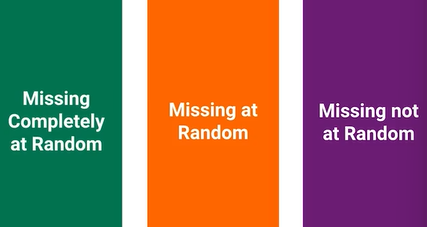

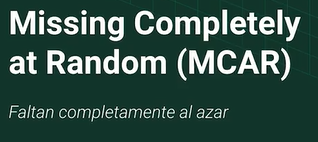  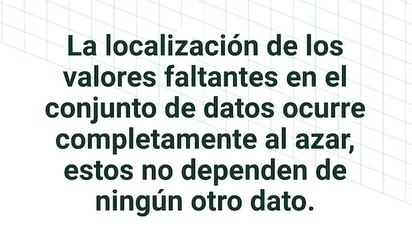


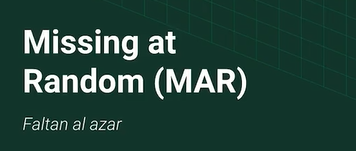  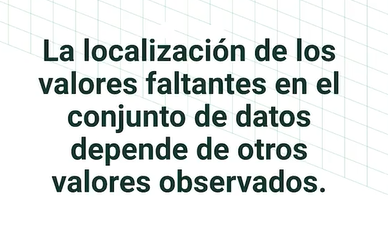

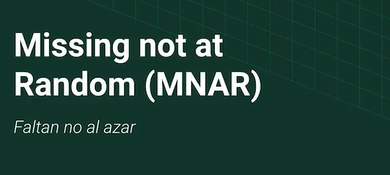  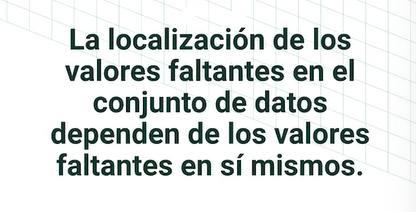

In [22]:
import pandas as pd

df = pd.read_csv('diabetes.csv')

df


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [24]:
%run ./pandas-missing-extension.ipynb

NBFormatError: Unsupported nbformat version 4

In [14]:
df.missing.missing_variale_plot()

AttributeError: 'MissingMethods' object has no attribute 'missing_variale_plot'

In [10]:
(
    df
    .missing
    .missing_upsetplot(
        variables = None,
        element_size = 60
    )
)

AttributeError: 'MissingMethods' object has no attribute 'missing_upsetplot'

In [11]:
df[df.columns[1:6]].replace(0, np.nan)

,Glucose,BloodPressure,SkinThickness,Insulin,BMI
0,148.0,72.0,35.0,NaN,33.6
1,85.0,66.0,29.0,NaN,26.6
2,183.0,64.0,NaN,NaN,23.3
3,89.0,66.0,23.0,94.0,28.1
4,137.0,40.0,35.0,168.0,43.1
...,...,...,...,...,...
763,101.0,76.0,48.0,180.0,32.9
764,122.0,70.0,27.0,NaN,36.8
765,121.0,72.0,23.0,112.0,26.2
766,126.0,60.0,NaN,NaN,30.1


In [13]:
df.missing.missing_variable_plot()

AttributeError: 'MissingMethods' object has no attribute 'missing_variable_plot'

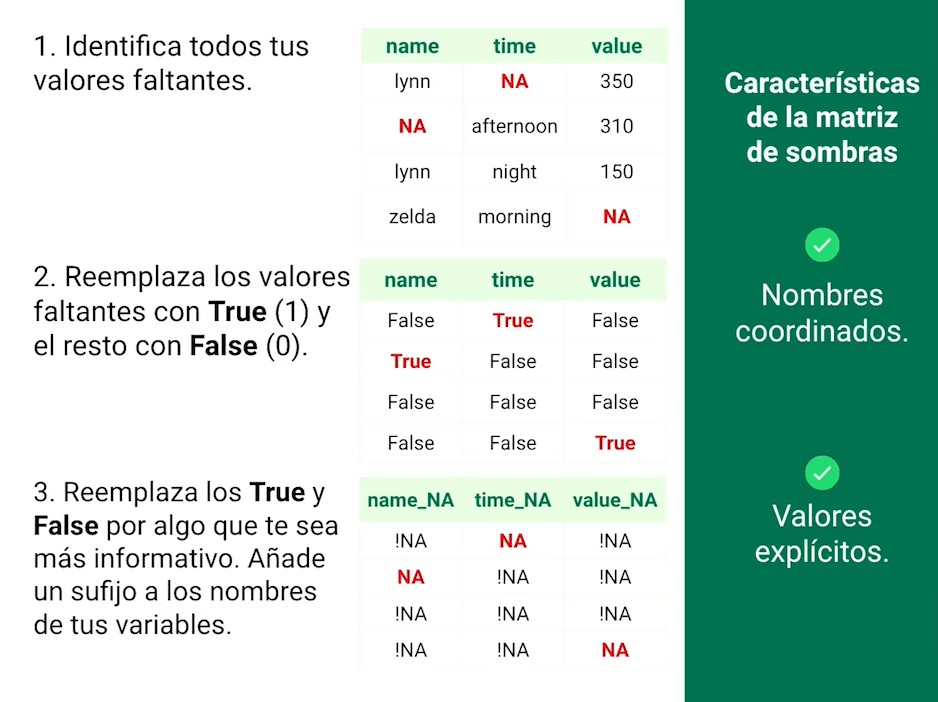

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from upsetplot import plot as upsetplot_plot

@pd.api.extensions.register_dataframe_accessor("missing")
class MissingMethods:
    def __init__(self, pandas_obj):
        self._obj = pandas_obj

    def number_missing(self) -> int:
        return self._obj.isna().sum().sum()

    def number_complete(self) -> int:
        return self._obj.size - self._obj.missing.number_missing()

    def missing_variable_summary(self) -> pd.DataFrame:
        return self._obj.isnull().pipe(
            lambda df_1: (
                df_1.sum()
                .reset_index(name="n_missing")
                .rename(columns={"index": "variable"})
                .assign(
                    n_cases=len(df_1),
                    pct_missing=lambda df_2: df_2.n_missing / df_2.n_cases * 100,
                )
            )
        )

    def missing_case_summary(self) -> pd.DataFrame:
        return self._obj.assign(
            case=lambda df: df.index,
            n_missing=lambda df: df.apply(
                axis="columns", func=lambda row: row.isna().sum()
            ),
            pct_missing=lambda df: df["n_missing"] / df.shape[1] * 100,
        )[["case", "n_missing", "pct_missing"]]

    def missing_variable_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_variable_summary()
            .value_counts("n_missing")
            .reset_index(name="n_variables")
            .rename(columns={"n_missing": "n_missing_in_variable"})
            .assign(
                pct_variables=lambda df: df.n_variables / df.n_variables.sum() * 100
            )
            .sort_values("pct_variables", ascending=False)
        )

    def missing_case_table(self) -> pd.DataFrame:
        return (
            self._obj.missing.missing_case_summary()
            .value_counts("n_missing")
            .reset_index(name="n_cases")
            .rename(columns={"n_missing": "n_missing_in_case"})
            .assign(pct_case=lambda df: df.n_cases / df.n_cases.sum() * 100)
            .sort_values("pct_case", ascending=False)
        )

    def missing_variable_span(self, variable: str, span_every: int) -> pd.DataFrame:
        df = self._obj.copy()
        df["span_counter"] = np.floor(np.arange(df.shape[0]) / span_every).astype(int)

        return (
            df
            .groupby("span_counter")
            .aggregate(
                n_in_span=(variable, "size"),
                n_missing=(variable, lambda s: s.isnull().sum()),
            )
            .assign(
                n_complete=lambda df: df.n_in_span - df.n_missing,
                pct_missing=lambda df: df.n_missing / df.n_in_span * 100,
                pct_complete=lambda df: 100 - df.pct_missing,
            )
            .drop(columns=["n_in_span"])
            .reset_index()
        )

    def missing_variable_run(self, variable) -> pd.DataFrame:
        rle_list = self._obj[variable].pipe(
            lambda s: [[len(list(g)), k] for k, g in itertools.groupby(s.isnull())]
        )

        return pd.DataFrame(data=rle_list, columns=["run_length", "is_na"]).replace(
            {False: "complete", True: "missing"}
        )

    def sort_variables_by_missingness(self, ascending=False):
        return (
            self._obj
            .pipe(lambda df: df[df.isna().sum().sort_values(ascending=ascending).index])
        )

    def create_shadow_matrix(
        self,
        true_string: str = "Missing",
        false_string: str = "Not Missing",
        only_missing: bool = False,
    ) -> pd.DataFrame:
        shadow_df = self._obj.isna().replace({True: true_string, False: false_string})
        
        if only_missing:
            shadow_df = shadow_df.loc[:, self._obj.isna().any()]
        
        # Agrega el sufijo '_NA' a cada columna para diferenciar
        shadow_df.columns = [f"{col}_NA" for col in shadow_df.columns]
        return shadow_df



C:\Users\Admin\AppData\Local\Temp\ipykernel_14304\2846392680.py:8: UserWarning: registration of accessor <class '__main__.MissingMethods'> under name 'missing' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("missing")
